# Ceph Baseliner

In order for Ceph experiments to be valid, the cluster must exhibit certain properties. The requirements for the Ceph cluster are enumerated in these sets of experiments. These benchmarks should be run before starting any experiments as a sanity check and to verify that the cluster is working properly. The Ceph configuration and the number of repetitions for these benchmarks can be found in the [ansible/group_vars/all](../ansible/group_vars/all) configuration file. 

In [1]:
import sys, glob, os, re, warnings, matplotlib, datetime, pandas, numpy
%matplotlib inline

This notebook graphs the baseline measurements in of the results in:

In [2]:
os.listdir("../results")

['radosbench-hosts-run0-2018-02-02_16:11:14.702704',
 'radosbench-hosts-run2-2018-02-02_16:15:25.621095',
 'radosbench-hosts-run1-2018-02-02_16:13:19.685664',
 'osdbench-hosts-run1-2018-02-02_16:20:14.924055',
 'osdbench-hosts-run0-2018-02-02_16:19:59.819453',
 'netbench-hosts-2018-02-02_16:19:58.523727',
 'osdbench-hosts-run2-2018-02-02_16:20:30.881877']

## RADOSBENCH
First, we check the macro-level performance of the cluster. We use the RADOS CLI and configure the benchmarking tool to hammer the cluster with writes for 2 minutes. More specifically, the benchmark achieves this by:

```
Maintaining 16 concurrent writes of 4194304 bytes to objects of size 4194304 for up to 1 seconds or 0 objects
```

For further reading, check out this [tutorial](http://tracker.ceph.com/projects/ceph/wiki/Benchmark_Ceph_Cluster_Performance).

**Command**: `rados -p rbd bench --show-time 120 write`

**Expectation**: sustained throughput equal to the throughput of either the slowest disk or the network speed.

In [3]:
# parse: slurp up the RADOSBENCH output into a Pandas data frame
RADOSBENCH_COLHEADERS = ("date", "time", "sec", "Cur ops", "started", "finished", "avg MB/s", "cur MB/s", "last lat(s)", "avg lat(s)")
results = "../results/"

df_thruput = pandas.DataFrame()
for fname in glob.glob(results + "/radosbench-*"):
    df = pandas.DataFrame(columns=RADOSBENCH_COLHEADERS)
    with open(fname, "r") as input:
        for line in input:
            if not re.search('[a-zA-Z]', line): # skip lines that don't have raw numbers
                df.loc[len(df)] = line.split()  # add this line to end of the data frame
    df_thruput[fname] = df['avg MB/s']

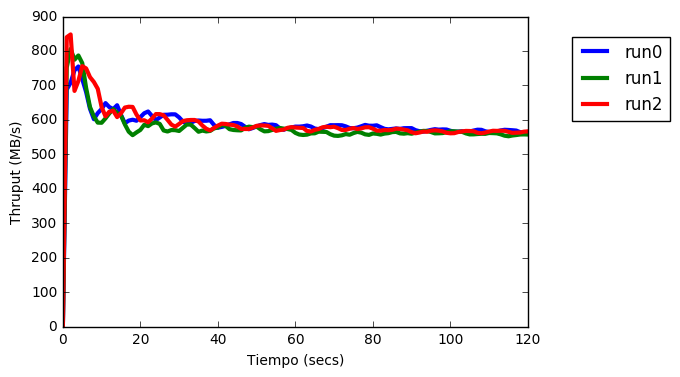

In [4]:
# plot: graph a time series of instantaneous throughput

fig = matplotlib.pyplot.figure()
ax = fig.add_subplot(111)

for fname in sorted(glob.glob(results + "/radosbench-*")):
    label = fname.split('-')[2]
    ax.plot(df_thruput[fname], markersize=10, linewidth=3.0, label=label)
    
ax.set_ylabel("Thruput (MB/s)")
ax.set_xlabel("Tiempo (secs)")

ax.legend(loc='center', bbox_to_anchor=(1.2, 0.8))
matplotlib.pyplot.savefig('radosbench.png', dpi=300, bbox_inches='tight')

## OSDBENCH
Check the performance of each individual OSD using OSD bench tool packaged with the Ceph CLI. This should give the raw write performance going through the Ceph stack (e.g., the "Ceph IO"). Specifically: 

```json
{
    "bytes_written": 1073741824,
    "blocksize": 4194304,
    "bytes_per_sec": <???>
}
```

For further reading, check out this [blog](https://www.sebastien-han.fr/blog/2013/10/03/quick-analysis-of-the-ceph-io-layer/).

**Command**: form the monitor:
```bash
for i in `seq 0 <NUM_OSDS>`; do
  ceph tell osd.$i bench
done
```

**Expectation**: the performance of RADOS bench should be *close enough* to the speed of the slowest OSD.

In [5]:
# parse: convert the raw results to valid JSON

df = pandas.DataFrame()
for fname in glob.glob(results + "/osdbench-*"):
    with open(fname, 'rb') as f:
        data = f.read().replace('\n', '')
    data = map(lambda x: x.replace("}", "},"), data) # separate records with a comma
    data[len(data)-1] = "}"                          # except the last record; no comma there!
    data = "[" + ''.join(data) + "]"                 # squash it into an array
    data = pandas.read_json(data)                        # read the data into a data frame
    df[fname] = data['bytes_per_sec']/(1024*1024)    # convert to megabytes

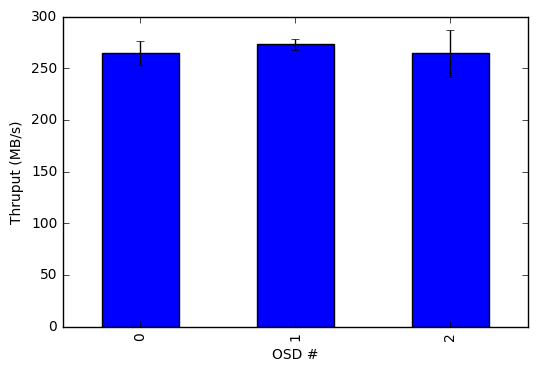

In [6]:
# plot: graph the mean and standard deviation of each OSD's write performance.

fig = matplotlib.pyplot.figure()
ax = fig.add_subplot(111)
df.mean(axis=1).plot(kind='bar', yerr=df.std(axis=1))

ax.set_ylabel("Thruput (MB/s)")
ax.set_xlabel("OSD #")
matplotlib.pyplot.savefig('osdbench.png', dpi=300, bbox_inches='tight')

## NETBENCH
Check the performance of the network. We use the the simple network performance benchmarking pool called `iperf`. This gives the raw network transfer speed over TCP. Specifically: 

```
------------------------------------------------------------
Server listening on TCP port 5001
TCP window size: 85.3 KByte (default)
------------------------------------------------------------
[ ID] Interval       Transfer     Bandwidth
[  4]  0.0-10.0 sec  1.10 GBytes   <???> Mbits/sec
```

For further reading, check out this [tutorial](http://tracker.ceph.com/projects/ceph/wiki/Benchmark_Ceph_Cluster_Performance).

**Command**: `iperf -c <MON_IP>`

**Expectation**: the performance of RADOS bench should be *close enough* to the speed of the slowest network connection.

In [7]:
# parse: read in the CSV and specify the format; then calculate the means/stds

for fname in glob.glob(results + "/netbench-*"):
    df = pandas.read_csv(fname, names=["date", "server_ip", "server_port", "client_ip", "client_port",
                                     "id", "interval", "transfer", "bandwidth"])
means = []
error = []
for client in df['client_ip'].unique():
    data = df[(df['client_ip'] == client)]['bandwidth']/(1000*1000*1000)
    means.append(data.mean())
    error.append(data.std())

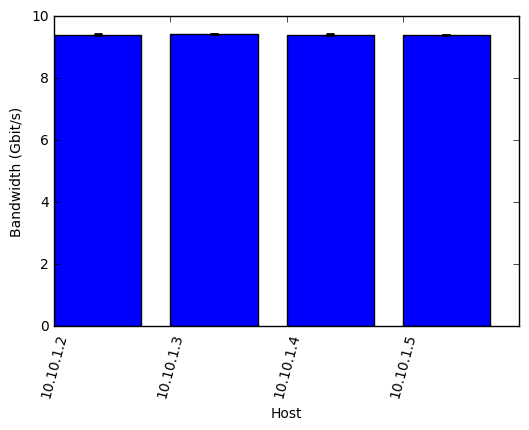

In [8]:
# plot: graph the mean and standard deviation of each Ceph daemon's connection to the MON

fig = matplotlib.pyplot.figure()
ax = fig.add_subplot(111)
  
x = numpy.arange(len(means))
matplotlib.pyplot.bar(x, means, width=0.75, 
        yerr=error, error_kw=dict(ecolor="black", capthick=2))
matplotlib.pyplot.xticks(x, df['client_ip'].unique(), rotation='75')

ax.set_ylabel("Bandwidth (Gbit/s)")
ax.set_xlabel("Host")
matplotlib.pyplot.savefig('netbench.png', dpi=300, bbox_inches='tight')